In [ ]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

# Upload kaggle API key file
uploaded = files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip \*.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jpg  
  inflating: seg_train/seg_train/mountain/7695.jp

In this notebook we will try to make a classifier using pretrained Model**(Mobilnetv2)** trained on imagenet dataset and mould it to make a classifier to make predictions on this dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os

In [ ]:
test_dir = '/content/seg_test/seg_test'

In [ ]:
train_dir = '/content/seg_train/seg_train'

In [ ]:
pred_dir = '/content/seg_pred/seg_pred'

In [ ]:
# this is done so if there are any image of variable shapes so we will reshape all of them to an average shape
dim1 = []
dim2 = []

for image_file in os.listdir(train_dir+'/buildings'):
    img = imread(train_dir+'/buildings/'+image_file)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

In [ ]:
height = int(np.average(d1))
height

150

In [ ]:
width = int(np.average(d2))
width

150

In [ ]:
img_shape = (height,width,3)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# performing data augmentation and scaling on train set
image_gen_train = ImageDataGenerator(rescale=1/255,
                                    horizontal_flip=True,
                                    zoom_range=0.5,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.1,
                                    rotation_range=10,
                                    fill_mode='nearest')

In [ ]:
# performing scaling on test set
image_gen_test = ImageDataGenerator(rescale=1/255)

In [ ]:
# returns an iterator of tuples of (x,y)
# here x is like our x_train and y like y_train
train_data_gen = image_gen_train.flow_from_directory(directory=train_dir,
                                                    class_mode='categorical',
                                                    batch_size=128,
                                                    color_mode='rgb',
                                                    shuffle=True,
                                                    target_size=img_shape[:2])

Found 14034 images belonging to 6 classes.


In [ ]:
# returns an iterator of tuples of (x,y)
# here x is like our x_train and y like y_train
test_data_gen = image_gen_test.flow_from_directory(directory=test_dir,
                                                  class_mode='categorical',
                                                  color_mode='rgb',
                                                  batch_size=128,
                                                  target_size=img_shape[:2],
                                                  shuffle=False)

Found 3000 images belonging to 6 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import InceptionV3

In [ ]:
# instantiating a base model which we will not be trained and we'll import this model along with trained weights and biases
# (actually this model was trained on imagenet dataset) we'll not include top of layers of that model because they are less generic
# instead we'll add on more layers later so that this model could make predictions on this dataset.
base_model = MobileNetV2(include_top=False,
                        weights='imagenet',
                        input_shape=img_shape)

In [ ]:
base_model.trainable = False# freezing the base model layers to avoid it's retraining.

In [ ]:
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

In [ ]:
global_layer = GlobalAveragePooling2D() # this layer provides us a vetor of features from the just previous volume of base model.

In [ ]:
pred_layer = Dense(6) # this layer makes raw predictions i.e, it returns numbers as logits.

In [ ]:
model = Sequential([base_model,global_layer,pred_layer]) # our modified model.

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
model.compile(optimizer=Adam(),
             loss=CategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
history = model.fit(train_data_gen,
         validation_data=test_data_gen,
         epochs=15,
         callbacks=[early_stop])

Epoch 1/15
110/110 [==============================] - 78s 710ms/step - loss: 0.7035 - accuracy: 0.7393 - val_loss: 0.3622 - val_accuracy: 0.8750
Epoch 2/15
110/110 [==============================] - 77s 700ms/step - loss: 0.4513 - accuracy: 0.8358 - val_loss: 0.3223 - val_accuracy: 0.8867
Epoch 3/15
110/110 [==============================] - 77s 699ms/step - loss: 0.4121 - accuracy: 0.8470 - val_loss: 0.3030 - val_accuracy: 0.8957
Epoch 4/15
110/110 [==============================] - 77s 702ms/step - loss: 0.3981 - accuracy: 0.8556 - val_loss: 0.2932 - val_accuracy: 0.8980
Epoch 5/15
110/110 [==============================] - 77s 698ms/step - loss: 0.3873 - accuracy: 0.8575 - val_loss: 0.2891 - val_accuracy: 0.9010
Epoch 6/15
110/110 [==============================] - 77s 699ms/step - loss: 0.3796 - accuracy: 0.8596 - val_loss: 0.2920 - val_accuracy: 0.8930
Epoch 7/15
110/110 [==============================] - 77s 699ms/step - loss: 0.3644 - accuracy: 0.8644 - val_loss: 0.2810 - val_ac

In [ ]:
# trend of losses
loss_metrics = pd.DataFrame(model.history.history)
loss_metrics

,loss,accuracy,val_loss,val_accuracy
0,0.703529,0.739276,0.362158,0.875000
1,0.451260,0.835827,0.322269,0.886667
2,0.412083,0.847014,0.302968,0.895667
3,0.398053,0.855636,0.293203,0.898000
4,0.387271,0.857489,0.289115,0.901000
5,0.379607,0.859555,0.292042,0.893000
6,0.364426,0.864401,0.280994,0.900667
7,0.364250,0.865897,0.272792,0.903333
8,0.362492,0.865470,0.288349,0.893333
9,0.362923,0.867607,0.268638,0.898333


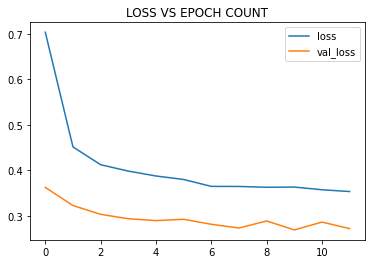

In [ ]:
loss_metrics[['loss','val_loss']].plot(title='LOSS VS EPOCH COUNT')

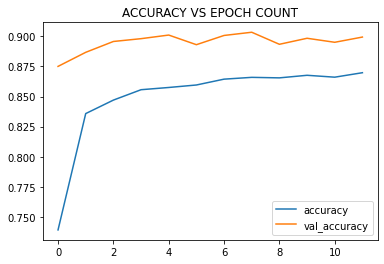

In [ ]:
loss_metrics[['accuracy','val_accuracy']].plot(title='ACCURACY VS EPOCH COUNT')

In [ ]:
test_data_gen.classes

array([0, 0, 0, ..., 5, 5, 5], dtype=int32)

In [ ]:
predictions = model.predict_classes(test_data_gen)
predictions

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([0, 0, 0, ..., 5, 5, 5])

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
print(classification_report(test_data_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       437
           1       0.97      1.00      0.98       474
           2       0.83      0.85      0.84       553
           3       0.83      0.82      0.83       525
           4       0.96      0.91      0.93       510
           5       0.92      0.91      0.92       501

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000



[[405   1   0   1   1  29]
 [  0 472   1   0   0   1]
 [  2   5 469  63   9   5]
 [  2   4  76 433   9   1]
 [  3   1  16  24 463   3]
 [ 39   2   1   1   2 456]]
Confusion matrix, without normalization
[[405   1   0   1   1  29]
 [  0 472   1   0   0   1]
 [  2   5 469  63   9   5]
 [  2   4  76 433   9   1]
 [  3   1  16  24 463   3]
 [ 39   2   1   1   2 456]]


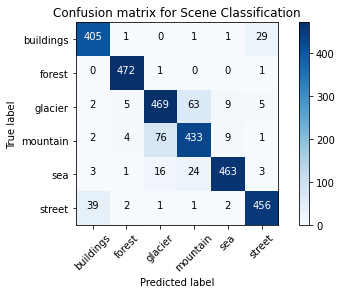

In [ ]:
print(confusion_matrix(test_data_gen.classes,predictions))
class_names = ['buildings','forest','glacier','mountain','sea','street']
cm = confusion_matrix(test_data_gen.classes,predictions)
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap="Blues"):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.figure()
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix for Scene Classification')

In [ ]:
def predict_label(class_number):
    if class_number==0:
        return 'building'
    elif class_number==1:
        return 'forest'
    elif class_number==2:
        return 'glacier'
    elif class_number==3:
        return 'mountain'
    elif class_number==4:
        return 'sea'
    else:
        return 'street'

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
def predict_name(directory_to_img):
    pred_image = image.load_img(directory_to_img,target_size=img_shape)
    pred_image_array = image.img_to_array(pred_image)
    pred_image_array = pred_image_array/255
    pred_image_array = pred_image_array.reshape(1,150,150,3)
    prediction = model.predict_classes(pred_image_array)[0]
    plt.imshow(imread(directory_to_img))
    return predict_label(prediction)

'building'

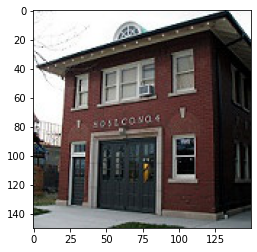

In [ ]:
predict_name('/content/seg_pred/seg_pred/'+os.listdir('/content/seg_pred/seg_pred/')[0])

'forest'

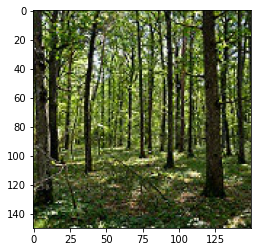

In [ ]:
predict_name(data_dir+'/seg_pred/seg_pred/'+os.listdir(data_dir+'/seg_pred/seg_pred/')[1])

'street'

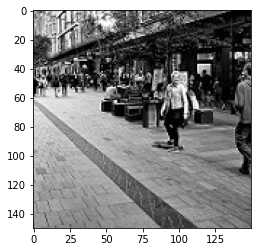

In [ ]:
predict_name(data_dir+'/seg_pred/seg_pred/'+os.listdir(data_dir+'/seg_pred/seg_pred/')[9])

'sea'

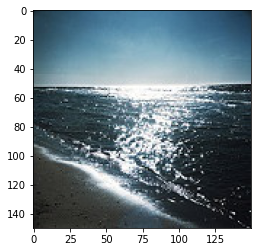

In [ ]:
predict_name(data_dir+'/seg_pred/seg_pred/'+os.listdir(data_dir+'/seg_pred/seg_pred/')[3])

'glacier'

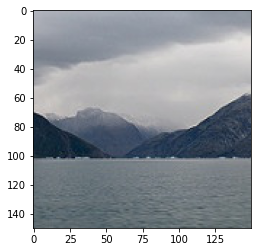

In [ ]:
predict_name(data_dir+'/seg_pred/seg_pred/'+os.listdir(data_dir+'/seg_pred/seg_pred/')[4])

'sea'

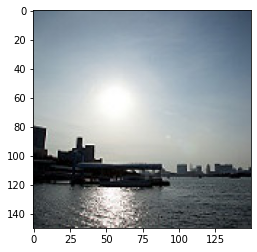

In [ ]:
predict_name(data_dir+'/seg_pred/seg_pred/'+os.listdir(data_dir+'/seg_pred/seg_pred/')[10])

'forest'

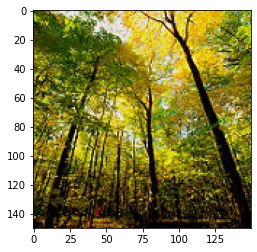

In [ ]:
predict_name(data_dir+'/seg_pred/seg_pred/'+os.listdir(data_dir+'/seg_pred/seg_pred/')[67])

'glacier'

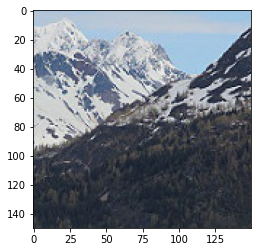

In [ ]:
predict_name(data_dir+'/seg_pred/seg_pred/'+os.listdir(data_dir+'/seg_pred/seg_pred/')[33])

'sea'

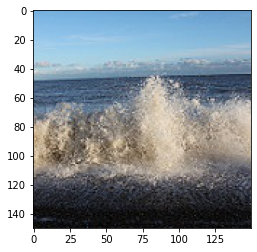

In [ ]:
predict_name(data_dir+'/seg_pred/seg_pred/'+os.listdir(data_dir+'/seg_pred/seg_pred/')[37])

'mountain'

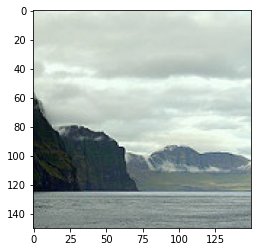

In [ ]:
predict_name(data_dir+'/seg_pred/seg_pred/'+os.listdir(data_dir+'/seg_pred/seg_pred/')[72])